In [ ]:
%pip install pandas
%pip install scikit-learn
%pip install lightgbm
%pip install matplotlib
%pip install imblearn
%pip install seaborn

In [1]:
import pandas as pd
import numpy as np
import gzip
import json
import matplotlib.pyplot as plt

## 1. Reading the Dataset

In [2]:
file_path = "../data/dataset0.json.gz"

def flatten_deep_data_ultra_fast(file_path, estimated_rows=11000000):
    """
    Ultra-optimized version with multiple improvements:
    - Batch processing to reduce index checks
    - Better memory allocation strategy
    - Faster resize logic
    - Direct array assignment
    
    Expected speedup: 2-3x
    """
    BATCH_SIZE = 10000
    GROWTH_FACTOR = 1.5
    
    # Pre-allocate arrays
    capacity = estimated_rows
    transcript_ids = np.empty(capacity, dtype=object)
    positions = np.empty(capacity, dtype=np.int32)
    seq = np.empty(capacity, dtype=object)
    feature_arrays = [np.empty(capacity, dtype=np.float32) for _ in range(9)]
    
    idx = 0
    batch_start = 0
    
    # Temporary batch storage
    batch_transcript_ids = []
    batch_positions = []
    batch_seq = []
    batch_features = [[] for _ in range(9)]
    
    def flush_batch():
        """Flush batch to main arrays"""
        nonlocal idx, batch_start, capacity
        
        batch_size = len(batch_transcript_ids)
        if batch_size == 0:
            return
        
        # Resize if needed
        while idx + batch_size > capacity:
            new_capacity = int(capacity * GROWTH_FACTOR)
            transcript_ids.resize(new_capacity, refcheck=False)
            positions.resize(new_capacity, refcheck=False)
            seq.resize(new_capacity, refcheck=False)
            for i in range(9):
                feature_arrays[i].resize(new_capacity, refcheck=False)
            capacity = new_capacity
        
        # Bulk assignment
        transcript_ids[idx:idx+batch_size] = batch_transcript_ids
        positions[idx:idx+batch_size] = batch_positions
        seq[idx:idx+batch_size] = batch_seq
        for i in range(9):
            feature_arrays[i][idx:idx+batch_size] = batch_features[i]
        
        idx += batch_size
        
        # Clear batch
        batch_transcript_ids.clear()
        batch_positions.clear()
        batch_seq.clear()
        for lst in batch_features:
            lst.clear()
    
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            for transcript_id, positions_dict in data.items():
                for transcript_position, sequences in positions_dict.items():
                    pos_int = int(transcript_position)
                    for sequence, feature_list in sequences.items():
                        for features in feature_list:
                            # Add to batch
                            batch_transcript_ids.append(transcript_id)
                            batch_positions.append(pos_int)
                            batch_seq.append(sequence)
                            for i, val in enumerate(features):
                                batch_features[i].append(val)
                            
                            # Flush when batch is full
                            if len(batch_transcript_ids) >= BATCH_SIZE:
                                flush_batch()
                                
                                if idx % 100000 == 0:
                                    print(f"Processed {idx:,} rows...", end='\r')
    
    # Flush remaining batch
    flush_batch()
    
    print(f"\nCreating DataFrame with {idx:,} rows...")
    
    # Trim and create DataFrame
    df = pd.DataFrame({
        'transcript_id': transcript_ids[:idx],
        'transcript_position': positions[:idx],
        'sequence': seq[:idx],
        'dwell_-1': feature_arrays[0][:idx],
        'std_-1': feature_arrays[1][:idx],
        'mean_-1': feature_arrays[2][:idx],
        'dwell_0': feature_arrays[3][:idx],
        'std_0': feature_arrays[4][:idx],
        'mean_0': feature_arrays[5][:idx],
        'dwell_+1': feature_arrays[6][:idx],
        'std_+1': feature_arrays[7][:idx],
        'mean_+1': feature_arrays[8][:idx],
    })
    
    return df

# executing the read function
df = flatten_deep_data_ultra_fast(file_path)

print("\n--- Flattened Read-Level DataFrame ---")
print(df.head())

Processed 11,000,000 rows...
Creating DataFrame with 11,027,106 rows...

--- Flattened Read-Level DataFrame ---
     transcript_id  transcript_position sequence  dwell_-1  std_-1  mean_-1  \
0  ENST00000000233                  244  AAGACCA   0.00299    2.06    125.0   
1  ENST00000000233                  244  AAGACCA   0.00631    2.53    125.0   
2  ENST00000000233                  244  AAGACCA   0.00465    3.92    109.0   
3  ENST00000000233                  244  AAGACCA   0.00398    2.06    125.0   
4  ENST00000000233                  244  AAGACCA   0.00664    2.92    120.0   

   dwell_0  std_0  mean_0  dwell_+1  std_+1    mean_+1  
0  0.01770  10.40   122.0   0.00930   10.90  84.099998  
1  0.00844   4.67   126.0   0.01030    6.30  80.900002  
2  0.01360  12.00   124.0   0.00498    2.13  79.599998  
3  0.00830   5.01   130.0   0.00498    3.78  80.400002  
4  0.00266   3.94   129.0   0.01300    7.15  82.199997  


In [3]:
# load the labels
labels = pd.read_csv("../data/data.info.labelled", sep=',')
print("\n--- Labels Dataframe ---")
print(labels.head())

# merge the labels with the read-level dataframe (adds gene_id)
merged_df = pd.merge(df, labels, on=["transcript_id", "transcript_position"], how='left')

print("\n--- Flattened Read-Level DataFrame Merged with Labels and Gene IDs ---")
print(merged_df.head())


--- Labels Dataframe ---
           gene_id    transcript_id  transcript_position  label
0  ENSG00000004059  ENST00000000233                  244      0
1  ENSG00000004059  ENST00000000233                  261      0
2  ENSG00000004059  ENST00000000233                  316      0
3  ENSG00000004059  ENST00000000233                  332      0
4  ENSG00000004059  ENST00000000233                  368      0

--- Flattened Read-Level DataFrame Merged with Labels and Gene IDs ---
     transcript_id  transcript_position sequence  dwell_-1  std_-1  mean_-1  \
0  ENST00000000233                  244  AAGACCA   0.00299    2.06    125.0   
1  ENST00000000233                  244  AAGACCA   0.00631    2.53    125.0   
2  ENST00000000233                  244  AAGACCA   0.00465    3.92    109.0   
3  ENST00000000233                  244  AAGACCA   0.00398    2.06    125.0   
4  ENST00000000233                  244  AAGACCA   0.00664    2.92    120.0   

   dwell_0  std_0  mean_0  dwell_+1  std_+1

## 2. Feature Engineering

In [4]:
data = pd.get_dummies(merged_df, columns=['sequence'])

print("\n--- DataFrame after One-Hot Encoding of Sequence ---")
data.head()


--- DataFrame after One-Hot Encoding of Sequence ---


,transcript_id,transcript_position,dwell_-1,std_-1,mean_-1,dwell_0,std_0,mean_0,dwell_+1,std_+1,...,sequence_TTGACAG,sequence_TTGACAT,sequence_TTGACCA,sequence_TTGACCC,sequence_TTGACCG,sequence_TTGACCT,sequence_TTGACTA,sequence_TTGACTC,sequence_TTGACTG,sequence_TTGACTT
0,ENST00000000233,244,0.00299,2.06,125.0,0.01770,10.40,122.0,0.00930,10.90,...,False,False,False,False,False,False,False,False,False,False
1,ENST00000000233,244,0.00631,2.53,125.0,0.00844,4.67,126.0,0.01030,6.30,...,False,False,False,False,False,False,False,False,False,False
2,ENST00000000233,244,0.00465,3.92,109.0,0.01360,12.00,124.0,0.00498,2.13,...,False,False,False,False,False,False,False,False,False,False
3,ENST00000000233,244,0.00398,2.06,125.0,0.00830,5.01,130.0,0.00498,3.78,...,False,False,False,False,False,False,False,False,False,False
4,ENST00000000233,244,0.00664,2.92,120.0,0.00266,3.94,129.0,0.01300,7.15,...,False,False,False,False,False,False,False,False,False,False


## 3. Train/Test Split and Model (LGBM) Training

In [7]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

# prepare feature matrix X and labels vector y
feature_cols = [col for col in data.columns if col not in ['gene_id', 'transcript_id', 'transcript_position', 'label']]
X = data[feature_cols]
y = data['label']
genes = data['gene_id']

# Train-test split by gene_id to avoid data leakage
unique_genes = genes.unique()
train_genes, test_genes = train_test_split(unique_genes, test_size=0.2, random_state=42)

train_mask = genes.isin(train_genes) # ensures all rows from a gene go to either train or test
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# # Handle class imbalances with SMOTE (commented out for now)
# smote = SMOTE(sampling_strategy='auto', random_state=42) # 'auto' allows SMOTE to upsample the minority class
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# print(f"Resampled Train shape: {X_train_resampled.shape}, Test shape: {X_test.shape}") 

# Train the LGBM model
clf = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)

# Predict on the test set
y_proba = clf.predict_proba(X_test)[:, 1]

Train shape: (8716187, 297), Test shape: (2310919, 297)
[LightGBM] [Info] Number of positive: 398443, number of negative: 8317744
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.196815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2793
[LightGBM] [Info] Number of data points in the train set: 8716187, number of used features: 297
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.045713 -> initscore=-3.038582
[LightGBM] [Info] Start training from score -3.038582


## 4. Model Evaluation

ROC-AUC: 0.8169
PR-AUC: 0.2496


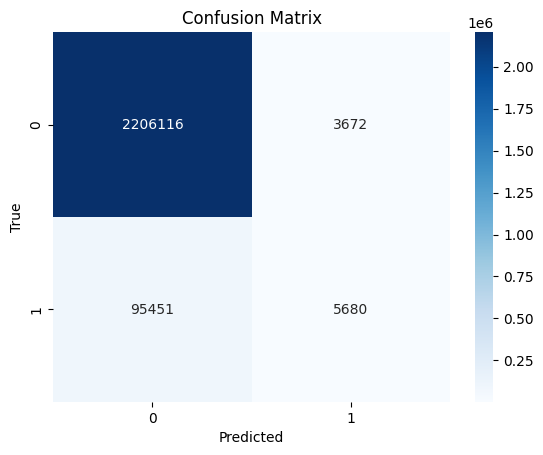

Text(0.5, 1.0, 'Precision-Recall Curve')

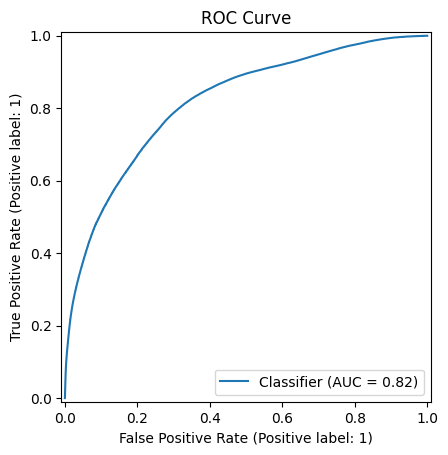

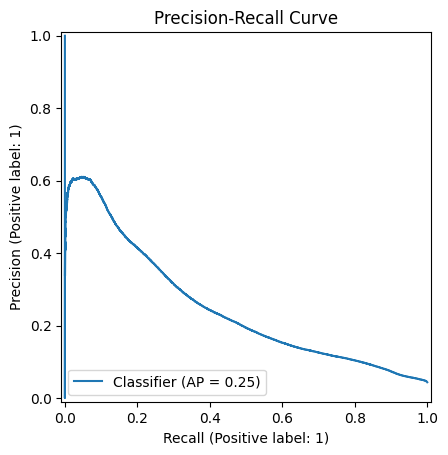

In [15]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
import seaborn as sns

# Binarize predictions with a threshold of 0.5
y_pred = (y_proba >= 0.5).astype(int) # threshold can be adjusted based on precision-recall tradeoff
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

# Precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print(f"PR-AUC: {pr_auc:.4f}")

# Confusion matrix using thresholded predictions
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title('ROC Curve')

# PR-AUC Curve
PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title('Precision-Recall Curve')

## 5. Feature Importances

              feature  importance
8             mean_+1        1873
5              mean_0        1826
2             mean_-1        1806
4               std_0        1015
1              std_-1         977
7              std_+1         821
6            dwell_+1         338
0            dwell_-1         327
3             dwell_0         321
31   sequence_AAGACTG          81
155  sequence_GAAACAG          59
141  sequence_CTGACAA          59
214  sequence_GTGACAC          58
181  sequence_GGAACCA          57
9    sequence_AAAACAA          56
33   sequence_AGAACAA          56
17   sequence_AAAACTA          55
144  sequence_CTGACAT          55
271  sequence_TGGACTG          51
13   sequence_AAAACCA          51


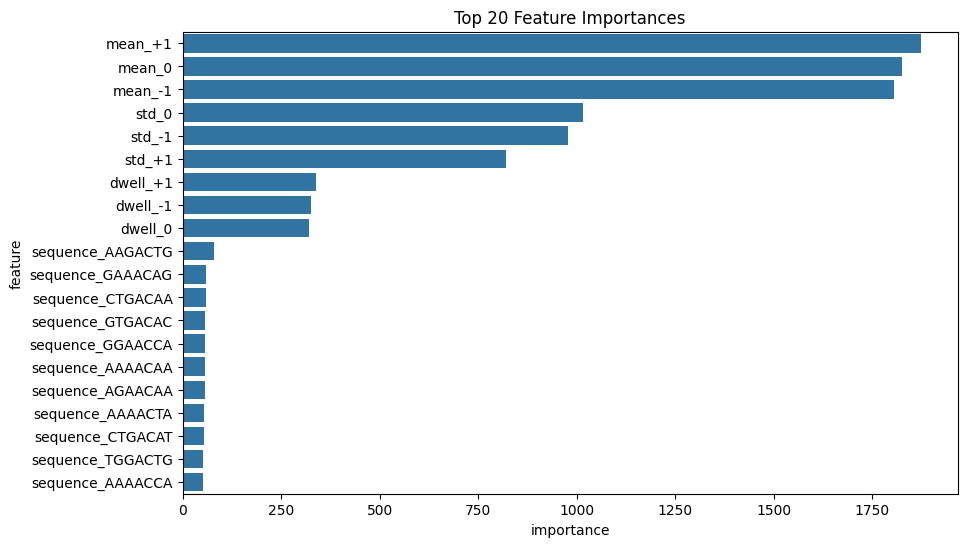

In [ ]:
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': clf.feature_importances_
}).sort_values(by='importance', ascending=False)

print(importances.head(20))

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=importances.head(20))
plt.title('Top 20 Feature Importances')
plt.show()

From the above graph, sequence features contribute very little to the model. May not be worth keeping due to:
- Memory concerns
- Interpolation does not exactly make sense on one-hot encoded, categorical data with SMOTE

## 6. Re-run of Model without sequence data

In [22]:
# prepare feature matrix X and labels vector y
feature_cols = [col for col in data.columns if col.startswith(('dwell', 'std', 'mean'))]
X = data[feature_cols]
y = data['label']
genes = data['gene_id']

# Train-test split by gene_id to avoid data leakage
unique_genes = genes.unique()
train_genes, test_genes = train_test_split(unique_genes, test_size=0.2, random_state=42)

train_mask = genes.isin(train_genes) # ensures all rows from a gene go to either train or test
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Handle class imbalances with SMOTE (commented out for now)
smote = SMOTE(sampling_strategy='auto', random_state=42) # 'auto' allows SMOTE to upsample the minority class
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled Train shape: {X_train_resampled.shape}, Test shape: {X_test.shape}") 

# Train the LGBM model
clf = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)

# Predict on the test set
y_proba = clf.predict_proba(X_test)[:, 1]

Train shape: (8716187, 9), Test shape: (2310919, 9)
Resampled Train shape: (16635488, 9), Test shape: (2310919, 9)
[LightGBM] [Info] Number of positive: 398443, number of negative: 8317744
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2217
[LightGBM] [Info] Number of data points in the train set: 8716187, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.045713 -> initscore=-3.038582
[LightGBM] [Info] Start training from score -3.038582


## 7. Model Evaluation (no sequence data)

ROC-AUC: 0.7983
PR-AUC: 0.2199


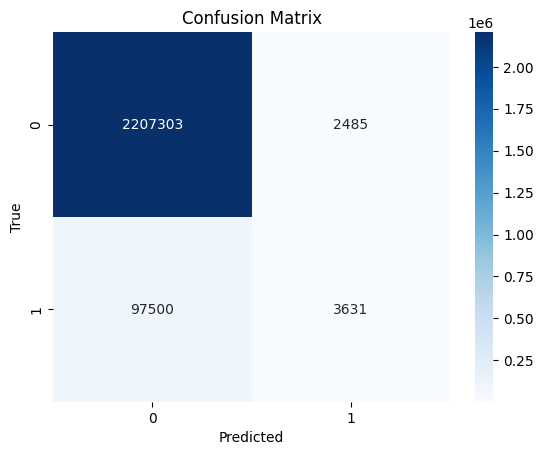

Text(0.5, 1.0, 'Precision-Recall Curve')

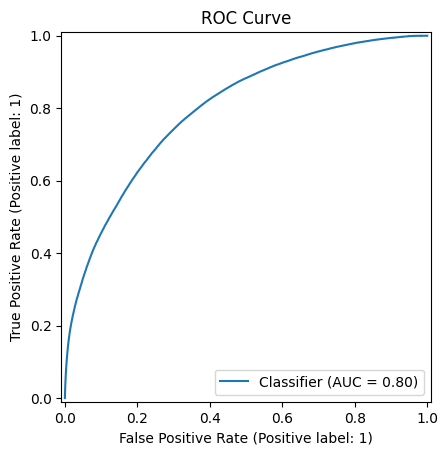

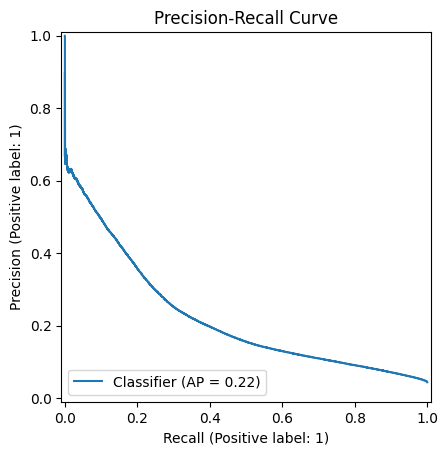

In [23]:
# Binarize predictions with a threshold of 0.5
y_pred = (y_proba >= 0.5).astype(int) # threshold can be adjusted based on precision-recall tradeoff

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

# Precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print(f"PR-AUC: {pr_auc:.4f}")

# Confusion matrix using thresholded predictions
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title('ROC Curve')

# PR-AUC Curve
PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title('Precision-Recall Curve')